In [2]:
import matplotlib.pyplot as plt
from torchvision import transforms

from flow_models.PatchNrFlowModel import PatchNrFlowModel
from img_utils import ImageLoader
from operators import BlurOperator
import torch
from dataset.FastPatchExtractor import FastImageLoader
from kernels import gaussian_kernel_generator
from regularisers import PatchNrRegulariser
import numpy as np
from transforms import image_normalization
from utils import plot_image
from variational_model_solver import variational_model_solver

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


In [4]:
patch_size = 6

In [5]:
#model_weights = torch.load('patchNR/patchNR_weights/weights_material.pth', map_location=DEVICE)
#model = create_NF(num_layers=5, sub_net_size=512, dimension=patch_size**2)
#model.load_state_dict(model_weights['net_state_dict'])

patchNrFlowModel = PatchNrFlowModel('patchNR/patchNR_weights/weights_material.pth', device=DEVICE)


5 512 36


In [6]:
patch_nr_regulariser = PatchNrRegulariser(patchNrFlowModel, p_size=patch_size, sample_number=50000, padding=True, padding_size=8, device=DEVICE)

In [56]:
kernel_size = 15
std = 10

In [57]:
gaussian_kernel = gaussian_kernel_generator(kernel_size, std).to(DEVICE)
blur_operator = BlurOperator(gaussian_kernel, device=DEVICE)

In [58]:
normalization = transforms.Compose([image_normalization()])
image_loader = ImageLoader('data/material_pt_nr/test.png', device=DEVICE, transform=normalization)
ground_truth = image_loader[0].to(DEVICE)

In [59]:
degraded_image = blur_operator(ground_truth)
c, w, h = degraded_image.shape

In [60]:
sigma = 0.1
mu = 0
noise_level = 5.
error_dim = w*h
noise_vector_std1 = torch.reshape(torch.tensor(np.random.normal(mu, sigma, error_dim), device=DEVICE), (1, w, h))
noise_degraded_image = degraded_image + normalization(noise_vector_std1*noise_level)

In [61]:
startpoint = noise_degraded_image.clone()

In [77]:
lam = 0

In [78]:
reconstructed = variational_model_solver(noise_degraded_image, startpoint, blur_operator, regulariser=patch_nr_regulariser, lam=lam, device=DEVICE)
img, loss_components = reconstructed

Loss: 1.2155884689783907; Likelihood: 1.2155884689783907 R: -84.56053161621094: 100%|██████████| 600/600 [02:49<00:00,  3.53it/s] 


In [79]:
rec_img = img.detach().cpu()
deg_img = degraded_image.detach().cpu()
gt_img = ground_truth.cpu()

In [80]:
plot_sel_patch_pos = (330, 330)
plot_patch_size = 50

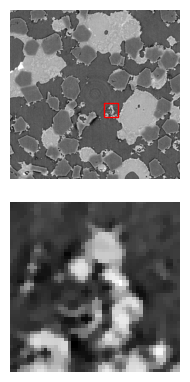

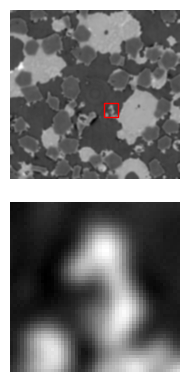

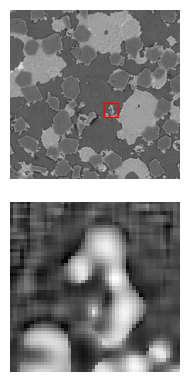

In [81]:
plot_image('results/deblurring/material/ground_truth.png', ground_truth, selected_patch=plot_sel_patch_pos, p_size=plot_patch_size)
plot_image(f'results/deblurring/material/orig_degraded_input_noise_{noise_level}_k_{kernel_size}_std_{std}.png', noise_degraded_image, selected_patch=plot_sel_patch_pos, p_size=plot_patch_size)
plot_image(f'results/deblurring/material/orig_reconstructed_noise_{noise_level}_k_{kernel_size}_std_{std}_lam_{lam}.png', rec_img, selected_patch=plot_sel_patch_pos, p_size=plot_patch_size)

In [82]:
import skimage.metrics as skm

In [84]:
psnr_rec = skm.peak_signal_noise_ratio(gt_img.numpy(), rec_img.numpy())
mse_rec = skm.mean_squared_error(gt_img.numpy(), rec_img.numpy())
psnr_deg = skm.peak_signal_noise_ratio(gt_img.numpy(), deg_img.numpy())
mse_deg = skm.mean_squared_error(gt_img.numpy(), deg_img.numpy())

print(f'PSNR rec: {psnr_rec}, PSNR deg: {psnr_deg}')
print(f'MSE rec: {mse_rec}, MSE deg: {mse_deg}')

PSNR rec: 25.32552192132139, PSNR deg: 23.426864538445944
MSE rec: 0.002933916893950212, MSE deg: 0.004542694657165277


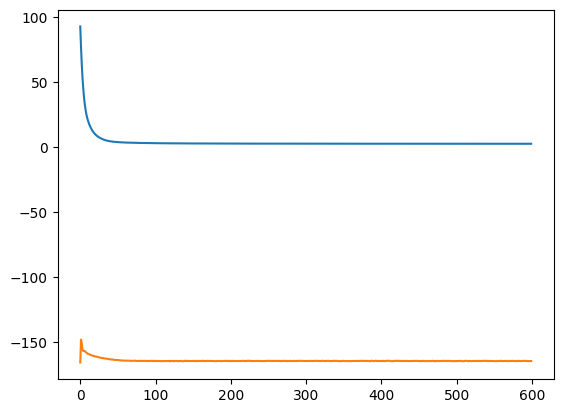

In [76]:
loss, likelihood, regularisation = loss_components
loss = torch.tensor(loss, device='cpu')
likelihood = torch.tensor(likelihood, device='cpu')
regularisation = torch.tensor(regularisation, device='cpu')

plt.plot([i for i in zip(
    #loss,
    likelihood,
    regularisation
)])